# Overview :
This is an implementation of a deep neural network from scratch to classify images from the Fashion MNIST dataset as either "sneaker" (label 1) or "non-sneaker" (label 0).

### Import the Libraries :

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# 1. Data Loading and Preprocessing


In [80]:
(train_images, train_labels), _ = fashion_mnist.load_data()


In [81]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

- train_images: Contains grayscale images of fashion items (shape: (60000, 28, 28)).
- train_labels: Contains labels for each image (values from 0 to 9).

### Creating a Binary Classification Dataset

In [82]:
sneaker_indices = np.where(train_labels == 7)[0] # extract Sneaker Images
non_sneaker_indices = np.where(train_labels != 7)[0] # extract non-Sneaker Images


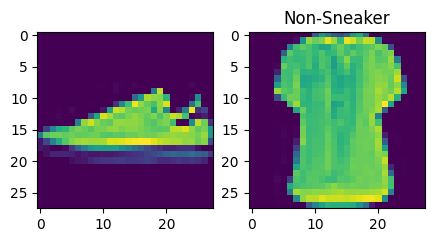

In [83]:
# Plotting the first sneaker image
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[sneaker_indices[0]])

# Plotting the first non-sneaker image
plt.subplot(1, 2, 2)
plt.imshow(train_images[non_sneaker_indices[50]])
plt.title('Non-Sneaker')

plt.show()

In [84]:
non_sneaker_sample_indices = np.random.choice(non_sneaker_indices, size=sneaker_indices.shape[0], replace=False)
balanced_indices = np.concatenate([sneaker_indices, non_sneaker_sample_indices])

# Balanced Dataset
X_balanced = train_images[balanced_indices]
y_balanced = train_labels[balanced_indices]
y_balanced = np.where(y_balanced == 7, 1, 0)


### Splitting into Training and Testing Sets

In [85]:
# Spliting dataset using sklearn
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced,
)


In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9600, 28, 28), (2400, 28, 28), (9600,), (2400,))

In [87]:
train_x_flatten = X_train.reshape(X_train.shape[0], -1).T  # Shape: (784, 9600)
test_x_flatten = X_test.reshape(X_test.shape[0], -1).T     # Shape: (784, 2400)

train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

y_train = y_train.reshape(1, -1)  # Shape: (1, 9600)
y_test = y_test.reshape(1, -1)    # Shape: (1, 2400)



In [88]:
train_x.shape, test_x.shape

((784, 9600), (784, 2400))

# 2. Parameter initialization

In [89]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = (
            np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        )
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters


Example :
`layer_dims = [784, 5, 1]`
- `W1`: Weight matrix of shape (5, 784), small random values.
- `b1`: Bias vector of shape (5, 1), initialized to zeros.
- `W2`: Weight matrix of shape (1, 5), small random values.
- `b2`: Bias scalar, initialized to zero.

# 3. Model Creation

##### Linear forward step

In [90]:
def linear_forward(A_prev, W, b):
    Z = W.dot(A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache


- `A_prev`: Activations from the previous layer.
- `W`: Weights matrix.
- `b`: Bias vector.
- `Z`: Linear component before activation.


##### Activation Functions

In [91]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache


In [92]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)

    return A, cache


#### Forward Propagation through layers

In [93]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    # Hidden layers with ReLU activation
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu"
        )
        caches.append(cache)

    # Output layer with Sigmoid activation
    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid"
    )
    caches.append(cache)

    return AL, caches

Simulation for NN with `[784, 5, 1]` layout:
- Input `X`: Shape `(784, m)` where `m` is the number of examples.
We take one example `(m = 1)` for simplicity.

- Layer 1 :
  - `A_prev(X)`: `Shape (784, 1)`.
  - `W1`: `Shape (5, 784)`.
  - `b1`: `Shape (5, 1)`.
  - Compute `Z1` = `W1.dot(A_prev) + b1: Shape (5, 1)`.
  - Apply ReLU: `A1 = relu(Z1): Shape (5, 1)`.

- Layer 2:

  - `A_prev(A1): Shape (5, 1)`.
  - `W2: Shape (1, 5`).
  - `b2: Scalar`.
  - `Compute Z2 = W2.dot(A1) + b2: Shape (1, 1)`.
  - Apply Sigmoid: `AL = sigmoid(Z2): Shape (1, 1)`.


### Calculate Cost

In [94]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (
        -1
        / m
        * np.sum(
            np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL))
        )
    )
    cost = np.squeeze(cost)
    return cost


- Suppose `AL = [[0.8]]` (model's prediction).
- True label `Y = [[1]]`.

  ```
  cost = - (1/m) * [Y * log(AL) + (1 - Y) * log(1 - AL)]
       = - [1 * log(0.8) + 0 * log(0.2)]
       = - log(0.8)
       ≈ 0.223
  ```


### Backward Propagation

##### Activation Function Backward

In [95]:
def sigmoid_backward(dA, cache):
    Z = cache
    A = 1 / (1 + np.exp(-Z))
    dZ = dA * A * (1 - A)
    return dZ

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


In [96]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1 / m * dZ.dot(A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T.dot(dZ)

    return dA_prev, dW, db


#### Linear Activation backward

In [97]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db


In [98]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    # Compute derivative of AL
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Backward for output layer (Sigmoid)
    current_cache = caches[L - 1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    # Backward for hidden layers (ReLU)
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)] = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")

    return grads


Simulation of Backprop :

- Output Layer (Layer 2):

Given:
- `AL = [[0.8]]`
- `Y = [[1]]`

- Derivative of AL :
  - `dAL = - (Y/AL - (1-Y)/(1-AL)) = - (1/0.8 - 0) = -1.25`

Backward through Sigmoid Activation :
  - `dZ2 = dAL * AL * (1 - AL) = -1.25 * 0.8 * 0.2 = -0.2`

Linear Backward:
- `A1`: From forward pass, shape `(5, 1)`. # Previous activation
- `W2: Shape (1, 5).` # W of ouput
- `dW2 = (1/m) * dZ2.dot(A1.T)`
- `db2 = (1/m) * np.sum(dZ2)`
- `dA1 = W2.T.dot(dZ2)`

Hidden Layer (Layer 1):

- Backward through ReLU Activation:
- From `dA1` and `Z1`,
  - compute `dZ1 = dA1 * (Z1 > 0)`
- Linear Backward:
  - `A0 (input X): Shape (784, 1).`
  - `W1: Shape (5, 784).`
  - `dW1 = (1/m) * dZ1.dot(A0.T)`
  - `db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)`
  - `dA0 = W1.T.dot(dZ1) # we don't need this`

Backprop Output :

- For Each Layer:
	- `dA`: Gradient of the loss with respect to the activation for the layer.
	- `dZ`: Gradient of the loss with respect to the pre-activation output (Z).
	- `dW`: Gradient of the loss with respect to the weights.
	- `db`: Gradient of the loss with respect to the biases.

#### Update Parameter :



In [99]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    return parameters


# 4. Model Training

In [100]:
def L_layer_model(
    X,
    Y,
    layers_dims,
    learning_rate=0.0075,
    num_iterations=1000,
    print_cost=False,
):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters(layers_dims)

    for i in range(num_iterations):
        # Forward Propagation
        AL, caches = L_model_forward(X, parameters)

        # Compute Cost
        cost = compute_cost(AL, Y)

        # Backward Propagation
        grads = L_model_backward(AL, Y, caches)

        # Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print and store the cost
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {cost}")
        if i % 100 == 0 or i == num_iterations - 1:
            costs.append(cost)

    return parameters, costs


In [101]:
# Making the input size
height, width = X_train.shape[1], X_train.shape[2]
input_size = height * width


layers_dims = [input_size, 5, 1]

In [102]:

parameters, costs = L_layer_model(
    train_x,
    y_train,
    layers_dims,
    num_iterations=1000,
    learning_rate=0.01,
    print_cost=True,
)


Cost after iteration 0: 0.6932697834842639
Cost after iteration 100: 0.6906996080171036
Cost after iteration 200: 0.66512952747064
Cost after iteration 300: 0.5556943958187671
Cost after iteration 400: 0.4596657696446482
Cost after iteration 500: 0.4036907904210939
Cost after iteration 600: 0.3615680752909119
Cost after iteration 700: 0.28285201258070986
Cost after iteration 800: 0.20112328362389398
Cost after iteration 900: 0.17480688681755782
Cost after iteration 999: 0.1632110658299695


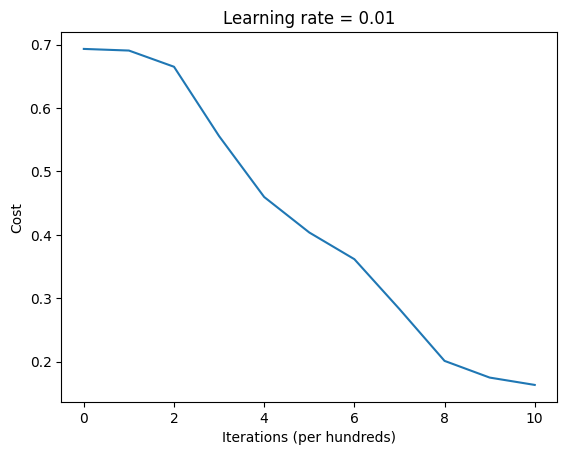

In [103]:
plt.plot(costs)
plt.ylabel("Cost")
plt.xlabel("Iterations (per hundreds)")
plt.title("Learning rate = " + str(0.01))
plt.show()


# 5. Model Evaluation

In [104]:
def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL >= 0.5).astype(int)
    return predictions


In [105]:
# Training Accuracy
train_predictions = predict(train_x, parameters)
train_accuracy = np.mean(train_predictions == y_train) * 100

# Testing Accuracy
test_predictions = predict(test_x, parameters)
test_accuracy = np.mean(test_predictions == y_test) * 100

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Train Accuracy: 93.95%
Test Accuracy: 94.38%


### Showing the ouput :

In [106]:
image_shape = (28, 28)

# Number of images to display
num_images_to_display = 5

# Select some random indices for displaying training and testing images
train_indices = np.random.choice(X_train.shape[0], num_images_to_display, replace=False)
test_indices = np.random.choice(X_test.shape[0], num_images_to_display, replace=False)



In [ ]:
def display_images(indices, X_data, y_data, predictions, image_shape, num_images, title_prefix):
    for i, idx in enumerate(indices):
        plt.subplot(2, num_images, i + 1)
        image = X_data[idx].reshape(image_shape)  # Reshape the image for display
        plt.imshow(image)
        plt.title(f"{title_prefix}: Pred {predictions[0, idx]}, Actual {y_data[0, idx]}")
        plt.axis('off')

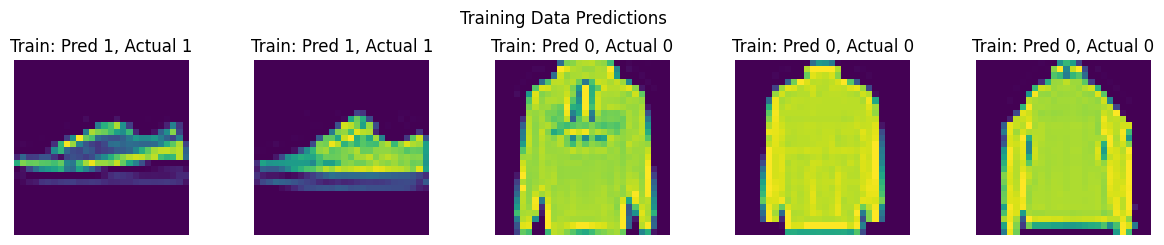

In [107]:
# Display training and testing data predictions
plt.figure(figsize=(15, 5))

# Displaying training images
display_images(train_indices, X_train, y_train, train_predictions, image_shape, num_images_to_display, 'Train')

plt.suptitle("Training Data Predictions")
plt.show()

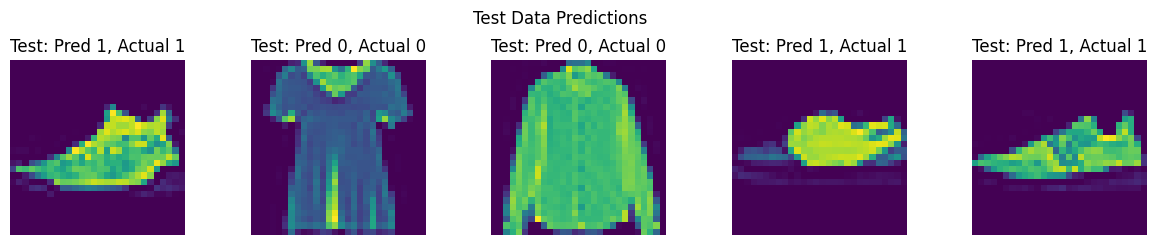

In [109]:
plt.figure(figsize=(15, 5))

# Displaying testing images
display_images(test_indices, X_test, y_test, test_predictions, image_shape, num_images_to_display, 'Test')


plt.suptitle("Test Data Predictions")
plt.show()